In [1]:
# UNCOMMENT AND MODIFY IF USING GOOGLE COLLAB

# # This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs682/assignment3/assignment3/'
FOLDERNAME = 'ColabNotebooks/cs682/assignment3/assignment3/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# # This downloads the COCO dataset to your Drive
# # if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs682/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/ColabNotebooks/cs682/assignment3/assignment3/cs682/datasets
/content/drive/My Drive/ColabNotebooks/cs682/assignment3/assignment3


# Image Captioning with Transformers

In this exercise, you will implement a Transformer decoder and use it to train a model that can generate novel captions for images.
**NOTE:** This notebook will be primarily written in PyTorch rather than NumPy, unlike previous assignments.

In [2]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs682.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs682.transformer_layers import *
from cs682.captioning_solver_transformer import CaptioningSolverTransformer
from cs682.classifiers.transformer import CaptioningTransformer
from cs682.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs682.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset

For this exercise, we will use the 2014 release of the [COCO dataset](https://cocodataset.org/), a standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

**Image features.** We have preprocessed the data and extracted features for you already. For all images, we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet, and these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5`. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512 using Principal Component Analysis (PCA), and these features are stored in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`. The raw images take up nearly 20GB of space so we have not included them in the download. Since all images are taken from Flickr, we have stored the URLs of the training and validation images in the files `train2014_urls.txt` and `val2014_urls.txt`. This allows you to download images on-the-fly for visualization.

**Captions.** Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` from the file `cs682/coco_utils.py` to convert NumPy arrays of integer IDs back into strings.

**Tokens.** There are a couple special tokens that we add to the vocabulary, and we have taken care of all implementation details around special tokens for you. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens.

# Data Setup

Download `coco_captioning.zip.1` and `imagenet_val_25.npz` from here: [COCO DATA](https://drive.google.com/drive/folders/1Xwz-8P2RhSrZSLnAbvtM227KZerRo4iN?usp=sharing) and place them in folder `cs682/datasets`. After downloading the files, unzip `coco_captioning.zip.1`.

You can load all of the COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `cs682/coco_utils.py`. Run the following cell to do so:

In [3]:
import os
print(os.path.exists('/content/drive/My Drive/ColabNotebooks/cs682/assignment3/assignment3/cs682/datasets/coco_captioning.zip'))

import zipfile
import os

zip_path = '/content/drive/My Drive/ColabNotebooks/cs682/assignment3/assignment3/cs682/datasets/coco_captioning.zip.1'
extract_path = '/content/drive/My Drive/ColabNotebooks/cs682/assignment3/assignment3/cs682/datasets'

# Check if the file exists
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")
else:
    print(f"File not found: {zip_path}")



False
Extraction complete!


In [4]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/My Drive/ColabNotebooks/cs682/assignment3/assignment3/cs682/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Inspect the Data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function from the file `cs682/coco_utils.py` to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

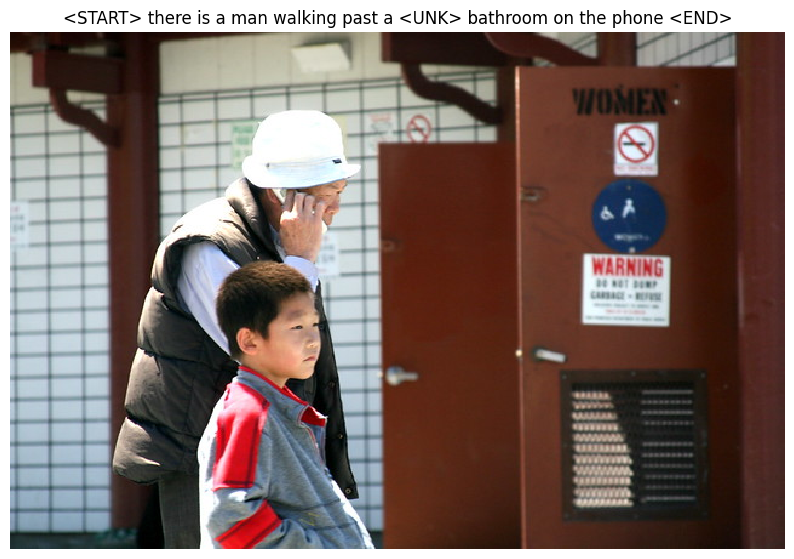

In [5]:
# Sample a minibatch and show the images and captions.
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
batch_size = 1

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Transformer

In 2017, Vaswani et al introduced the Transformer in their paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) to a) introduce parallelism and b) allow models to learn long-range dependencies. The paper not only led to famous models like BERT and GPT in the natural language processing community, but also an explosion of interest across fields, including vision. While here we introduce the model in the context of image captioning, the idea of attention itself is much more general.



# Transformer: Multi-Headed Attention

### Dot-Product Attention

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$, specified as

\begin{align}
c = \sum_{i=1}^{n} v_i \alpha_i\, &\alpha_i = \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
\end{align}

where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

### Multi-Headed Scaled Dot-Product Attention
In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $Q_i$, $K_i$ and $V_i$. To keep our overall computation the same as the single-headed case, we choose $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$ and $V_i \in \mathbb{R}^{d\times d/h}$. Adding in a scaling term $\frac{1}{\sqrt{d/h}}$ to our simple dot-product attention above, we have

\begin{equation}
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)
\end{equation}

where $Y_i\in\mathbb{R}^{\ell \times d/h}$, where $\ell$ is our sequence length.

In our implementation, we apply dropout to the attention weights (though in practice it could be used at any step):

\begin{equation}
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)\bigg)(XV_i)
\end{equation}

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

\begin{equation}
Y = [Y_1;\dots;Y_h]A
\end{equation}

were $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

Implement multi-headed scaled dot-product attention in the `MultiHeadAttention` class in the file `cs682/transformer_layers.py`. The code below will check your implementation. The relative error should be less than `e-3`.

In [6]:
torch.manual_seed(231)

# Choose dimensions such that they are all unique for easier debugging:
# Specifically, the following values correspond to N=1, H=2, T=3, E//H=4, and E=8.
batch_size = 1
sequence_length = 3
embed_dim = 8
attn = MultiHeadAttention(embed_dim, num_heads=2)

# Self-attention.
data = torch.randn(batch_size, sequence_length, embed_dim)
self_attn_output = attn(query=data, key=data, value=data)

# Masked self-attention.
mask = torch.randn(sequence_length, sequence_length) < 0.5
masked_self_attn_output = attn(query=data, key=data, value=data, attn_mask=mask)

# Attention using two inputs.
other_data = torch.randn(batch_size, sequence_length, embed_dim)
attn_output = attn(query=data, key=other_data, value=other_data)

expected_self_attn_output = np.asarray([[
[-0.2494,  0.1396,  0.4323, -0.2411, -0.1547,  0.2329, -0.1936,
          -0.1444],
         [-0.1997,  0.1746,  0.7377, -0.3549, -0.2657,  0.2693, -0.2541,
          -0.2476],
         [-0.0625,  0.1503,  0.7572, -0.3974, -0.1681,  0.2168, -0.2478,
          -0.3038]]])

expected_masked_self_attn_output = np.asarray([[
[-0.1347,  0.1934,  0.8628, -0.4903, -0.2614,  0.2798, -0.2586,
          -0.3019],
         [-0.1013,  0.3111,  0.5783, -0.3248, -0.3842,  0.1482, -0.3628,
          -0.1496],
         [-0.2071,  0.1669,  0.7097, -0.3152, -0.3136,  0.2520, -0.2774,
          -0.2208]]])

expected_attn_output = np.asarray([[
[-0.1980,  0.4083,  0.1968, -0.3477,  0.0321,  0.4258, -0.8972,
          -0.2744],
         [-0.1603,  0.4155,  0.2295, -0.3485, -0.0341,  0.3929, -0.8248,
          -0.2767],
         [-0.0908,  0.4113,  0.3017, -0.3539, -0.1020,  0.3784, -0.7189,
          -0.2912]]])

print('self_attn_output error: ', rel_error(expected_self_attn_output, self_attn_output.detach().numpy()))
print('masked_self_attn_output error: ', rel_error(expected_masked_self_attn_output, masked_self_attn_output.detach().numpy()))
print('attn_output error: ', rel_error(expected_attn_output, attn_output.detach().numpy()))

self_attn_output error:  0.0003775124598178026
masked_self_attn_output error:  0.0001526367643724865
attn_output error:  0.0003530104862933477


# Positional Encoding

While transformers are able to easily attend to any part of their input, the attention mechanism has no concept of token order. However, for many tasks (especially natural language processing), relative token order is very important. To recover this, the authors add a positional encoding to the embeddings of individual word tokens.

Let us define a matrix $P \in \mathbb{R}^{l\times d}$, where $P_{ij} = $

$$
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$$

Rather than directly passing an input $X \in \mathbb{R}^{l\times d}$ to our network, we instead pass $X + P$.

Implement this layer in `PositionalEncoding` in `cs682/transformer_layers.py`. Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-3` or less.

In [7]:
torch.manual_seed(231)

batch_size = 1
sequence_length = 2
embed_dim = 6
data = torch.randn(batch_size, sequence_length, embed_dim)

pos_encoder = PositionalEncoding(embed_dim)
output = pos_encoder(data)

expected_pe_output = np.asarray([[[-1.2340,  1.1127,  1.6978, -0.0865, -0.0000,  1.2728],
                                  [ 0.9028, -0.4781,  0.5535,  0.8133,  1.2644,  1.7034]]])

print('pe_output error: ', rel_error(expected_pe_output, output.detach().numpy()))

pe_output error:  0.00010421011374914356


# Inline Question 1

Several key design decisions were made in designing the scaled dot product attention we introduced above. Explain why the following choices were beneficial:
1. Using multiple attention heads as opposed to one.
2. Dividing by $\sqrt{d/h}$ before applying the softmax function. Recall that $d$ is the feature dimension and $h$ is the number of heads.
3. Adding a linear transformation to the output of the attention operation.

Only one or two sentences per choice is necessary, but be sure to be specific in addressing what would have happened without each given implementation detail, why such a situation would be suboptimal, and how the proposed implementation improves the situation.

**Your Answer:**

1. A single attention head focuses only on one type of relationahip in the input. Multiple heads allows the model to attend to different parts of the input simultaneously. This allows it to capture more diverse patterns.

2. The dot product of query and key will result in very large values as the dimension increases. This causes the gradients to be very small after going through the softmax function. This leads to unstable training. Dividing by $\sqrt{d/h}$ normalizes the magnitude of the dot product of query and key. This allows the softmax function to operate in a normal range, allowing for stable training

3. When transformations are not added, the output is a simple weighted sum of values, which limits the model's ability to adjust or refine the attended information. A linear transformation allows the model to learn mappings from attneded outputs to the final representation. This enhances the model's capacity to extract meaningful features for downstream task.


# Transformer for Image Captioning
Now that you have implemented the previous layers, you can combine them to build a Transformer-based image captioning model. Open the file `cs682/classifiers/transformer.py` and look at the `CaptioningTransformer` class.

Implement the `forward` function of the class. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-5` or less.

In [8]:
torch.manual_seed(231)
np.random.seed(231)

N, D, W = 4, 20, 30
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 3

transformer = CaptioningTransformer(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    num_heads=2,
    num_layers=2,
    max_length=30
)

# Set all model parameters to fixed values
for p in transformer.parameters():
    p.data = torch.tensor(np.linspace(-1.4, 1.3, num=p.numel()).reshape(*p.shape))

features = torch.tensor(np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D))
captions = torch.tensor((np.arange(N * T) % V).reshape(N, T))

scores = transformer(features, captions)
expected_scores = np.asarray([[[-16.9532,   4.8261,  26.6054],
         [-17.1033,   4.6906,  26.4844],
         [-15.0708,   4.1108,  23.2924]],
        [[-17.1767,   4.5897,  26.3562],
         [-15.6017,   4.8693,  25.3403],
         [-15.1028,   4.6905,  24.4839]],
        [[-17.2172,   4.7701,  26.7574],
         [-16.6755,   4.8500,  26.3754],
         [-17.2172,   4.7701,  26.7574]],
        [[-16.3669,   4.1602,  24.6872],
         [-16.7897,   4.3467,  25.4831],
         [-17.0103,   4.7775,  26.5652]]])
print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  5.056720614052482e-06


# Overfit Transformer Captioning Model on Small Data
Similar to the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use a `CaptioningSolverTransformer` class to train image captioning models. Open the file `cs682/captioning_solver_transformer.py` and read through the `CaptioningSolverTransformer` class; it should look very familiar.

Run the following to overfit the Transformer-based captioning model on a small dataset.

base dir  /content/drive/My Drive/ColabNotebooks/cs682/assignment3/assignment3/cs682/datasets/coco_captioning
(Iteration 1 / 200) loss: 5.023862
(Iteration 11 / 200) loss: 2.838946
(Iteration 21 / 200) loss: 1.969341
(Iteration 31 / 200) loss: 1.578748
(Iteration 41 / 200) loss: 1.207473
(Iteration 51 / 200) loss: 1.056668
(Iteration 61 / 200) loss: 0.725467
(Iteration 71 / 200) loss: 0.662795
(Iteration 81 / 200) loss: 0.441756
(Iteration 91 / 200) loss: 0.345822
(Iteration 101 / 200) loss: 0.260866
(Iteration 111 / 200) loss: 0.120514
(Iteration 121 / 200) loss: 0.086464
(Iteration 131 / 200) loss: 0.078946
(Iteration 141 / 200) loss: 0.065133
(Iteration 151 / 200) loss: 0.058298
(Iteration 161 / 200) loss: 0.037710
(Iteration 171 / 200) loss: 0.039861
(Iteration 181 / 200) loss: 0.021198
(Iteration 191 / 200) loss: 0.028377


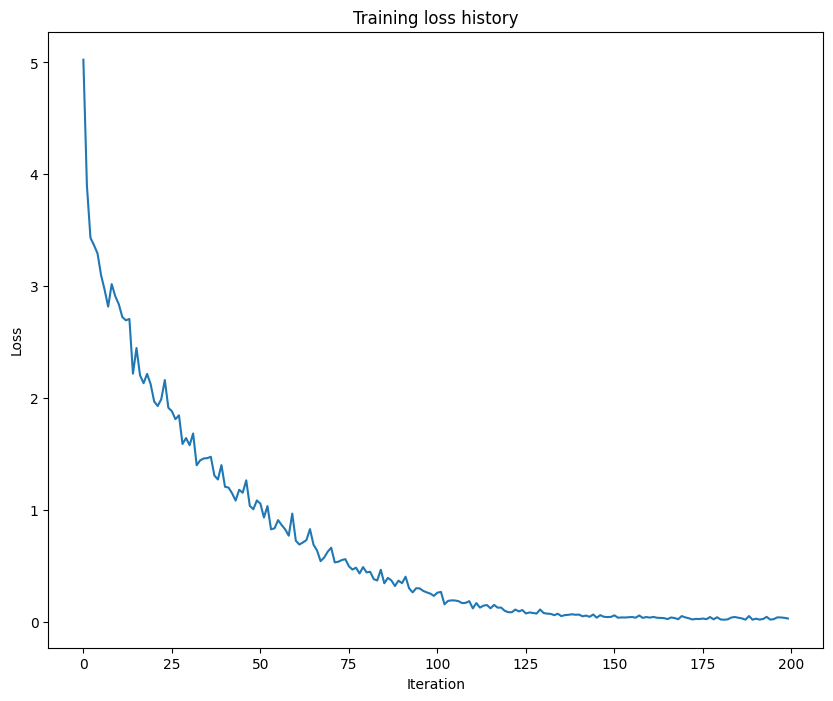

In [9]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(max_train=50)

transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        )


transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.03.

In [10]:
print('Final loss: ', transformer_solver.loss_history[-1])

Final loss:  0.029929006


# Transformer Sampling at Test Time
The sampling code has been written for you. You can simply run the following cell. As before the training results should be much better than the validation set results, given how little data we trained on.

URL Error:  Gone http://farm1.staticflickr.com/202/487987371_489a65d670_z.jpg


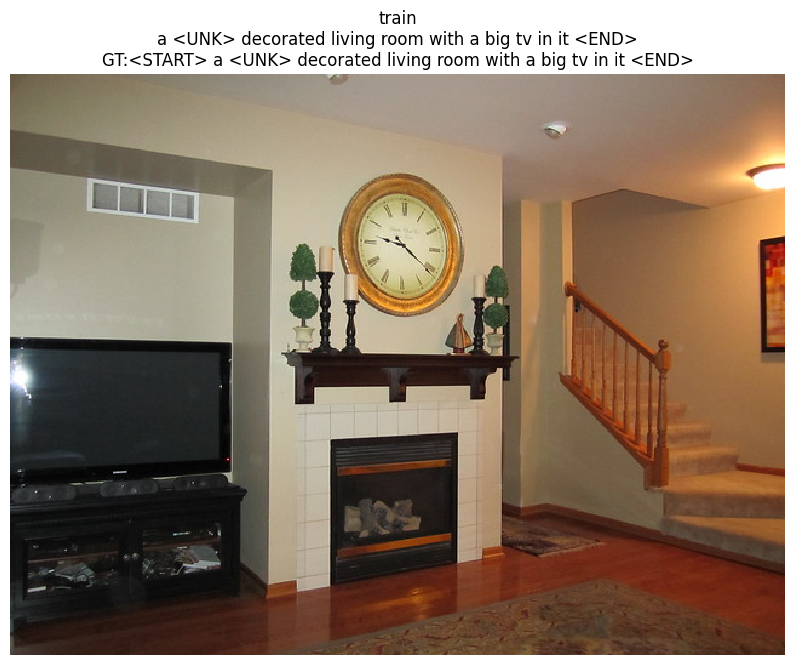

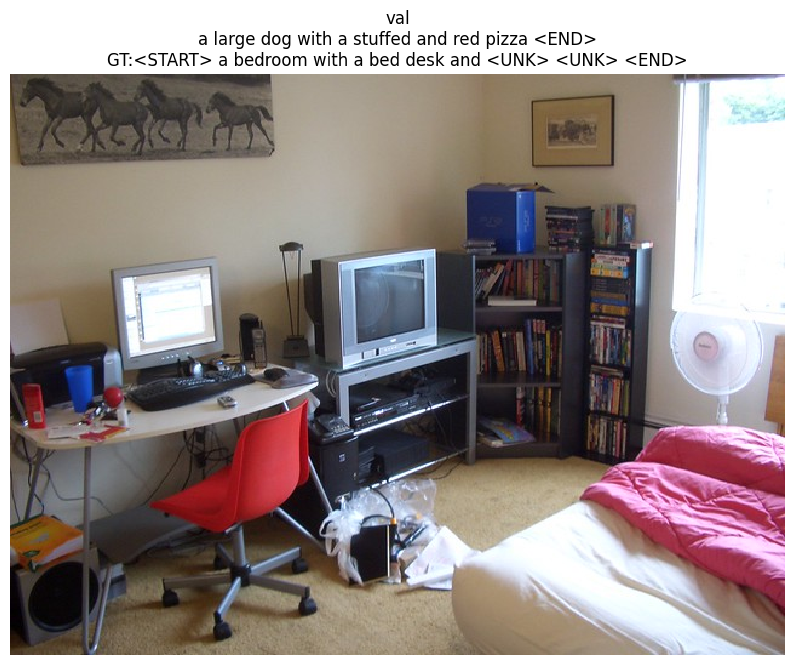

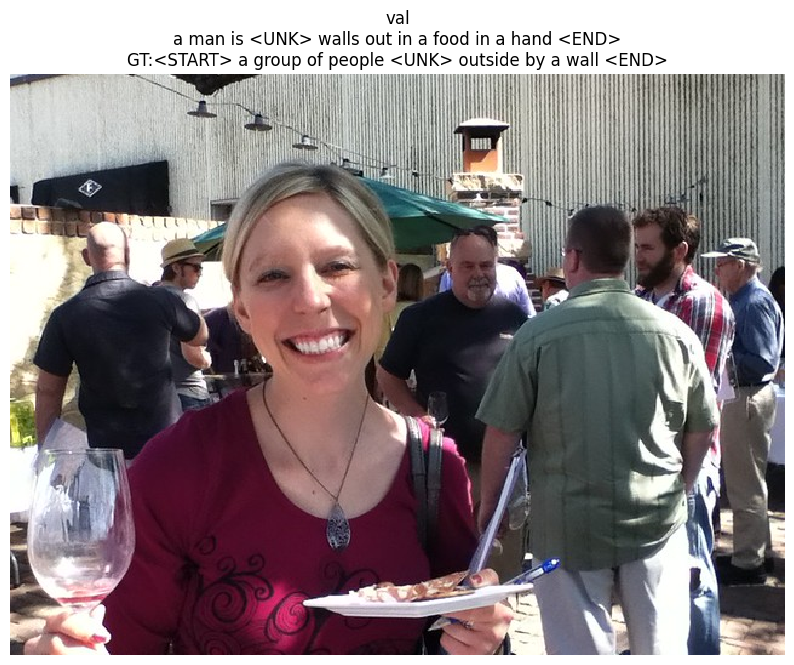

In [11]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()